<a href="https://colab.research.google.com/github/ProfDoeg/Colegio_Invisible/blob/main/18_cuaderno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
! pip install eciespy eth_keys cryptos qrcode
! git clone https://github.com/ProfDoeg/Colegio_Invisible.git
! cp Colegio_Invisible/modules/colegio_tools.py colegio_tools.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'Colegio_Invisible' already exists and is not an empty directory.


In [14]:
from colegio_tools import *

# Now We Have Colegio Tools

## Load Real Keys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [15]:
! cp drive/MyDrive/cinv/llaves.zip llaves.zip 
! unzip llaves.zip

Archive:  llaves.zip
replace llaves/mi_addr.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: llaves/mi_addr.bin      
 extracting: llaves/mi_addr.png      
 extracting: llaves/mi_pub.bin       
 extracting: llaves/mi_prv.enc       


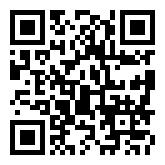

**************************************************
PUBLIC: 0x7c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5
ADDR: D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX
**************************************************
BALANCE:	 1164.917069
NUM_UTXO:	 1
**************************************************


In [16]:
my_qr=IPython.display.Image('llaves/mi_addr.png')
my_privKey=import_privKey('llaves/mi_prv.enc','')
my_pub=import_pubKey('llaves/mi_pub.bin')
my_addr=import_addr('llaves/mi_addr.bin')

display(my_qr)
print('*'*50)
print('PUBLIC:',my_pub)
print('ADDR:',my_addr)

import cryptos
doge=cryptos.Doge()

doge_unspents=doge.unspent(my_addr) 
doge_unspent_total=sum([unspent['value'] for unspent in doge_unspents])

print('*'*50)
print('BALANCE:\t',doge_unspent_total/10**8)
print('NUM_UTXO:\t',len(doge_unspents))
print('*'*50)

# Accessing Encypted Files From Blockchain

We will be accessing an encrypted color image file woven from transaction:

```d0209a0f85872d6826c58bc23fab37c8b21feb22c15a5a6469f45358fb78ba41```

Remeber the header data contains the following:
```text
b'\xc1\xdd\x00\x01\x0e\x03\x01'+length_bytes+width_bytes+bitnum_bytes+recip_bytes... + some_text_bytes
```

In [17]:
Txn='d0209a0f85872d6826c58bc23fab37c8b21feb22c15a5a6469f45358fb78ba41'

(head_d02,bytes_d02)=read_cadenas(Txn)

num_keys=int(head_d02[24:26])
zipkeys=[bytes_d02[i*64:i*64+64] for i in range(num_keys) ]
zipdata=bytes_d02[num_keys*64:]
print('HEADER:',head_d02)

txn_pub_hex=get_txn_pub(Txn)
print('AUTHOR:',txn_pub_hex)
print('NUM_RECIP:',num_keys)

HEADER: c1dd00010e03010040008005037c5468697320697320616e20656e6372797074656420696d61676520666f722074776f207370656369616c206c61646965732e2e2e486f6c617c
AUTHOR: 7c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5
NUM_RECIP: 3


3 64 128 5


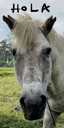

In [18]:
N=0

txn_pubKey=eth_keys.keys.PublicKey(bytes.fromhex(txn_pub_hex))
my_shared_key=shared_key(my_privKey,txn_pubKey)
ses_kee=ecies.aes_decrypt(my_shared_key,zipkeys[N])
data_do2=ecies.aes_decrypt(ses_kee,zipdata)
array_do2=read_image_data(head_d02,data_do2)

Image.fromarray(array_do2)

1 64 64 5


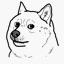

In [19]:

(d68_head,d68_array)=array_dec_from_txn('d68175766b70f7163aec93e5a4e81480a6c6dd51d0577319d6f3392e8725f53b',my_privKey,0)
Image.fromarray(d68_array)

# Key Drop

Create Transaction with op_return 

For key drop header is:

```text
b'\xc1\xdd\x00\x01\x0e\x0e\x0d'+text_bytes
```
and body is:
```
enc_txid_bytes+aes_key_bytes
```


In [22]:
drop_header=b'\xc1\xdd\x00\x01\x0e\x0e\x0d'+b'|Release something glorious to the world|'
enc_txid_bytes=bytes.fromhex('d0209a0f85872d6826c58bc23fab37c8b21feb22c15a5a6469f45358fb78ba41')
aes_key_bytes=ses_kee
drop_package=[drop_header]+[enc_txid_bytes+aes_key_bytes]
print(drop_package)

[b'\xc1\xdd\x00\x01\x0e\x0e\r|Release something glorious to the world|', b'\xd0 \x9a\x0f\x85\x87-h&\xc5\x8b\xc2?\xab7\xc8\xb2\x1f\xeb"\xc1ZZdi\xf4SX\xfbx\xbaA\x184pj\x14\xeddl\xb4\xcd-Q\xd1>`y\x94\x05^\xeb\xa4X\x1bnS\x93\x88\x9f4\xc0=]']


In [26]:
#prepare
tip=1_00_000_000
available=doge_unspent_total-tip
gift=int(available/len(drop_package))
outputs=[{'value':gift , 'address': my_addr} for i in range(len(drop_package))]
setup_tx=doge.mktx(doge_unspents,outputs)
print(gift/100_000_000)
print(len(outputs))

581.9585345
2


In [27]:
doge.signall(setup_tx,my_privKey.to_hex()[2:])

'010000000169c7af61b8f895d8e4e11e47cb651afa28e94cbd3b43efccd2019b1275bbf222000000008b483045022100c39299e289a6c2b18cfc4020ee1412bf96397507315e36fc33328d27fc735f9d02202d69a59a28408712b83dbeb670d291fab70f197c2afe8bdb219b8f94ca24c6ac0141047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5ffffffff028a40be8c0d0000001976a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac8a40be8c0d0000001976a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac00000000'

In [28]:
tip/(len(cryptos.serialize(setup_tx))/2)/100000

3.8759689922480622

In [29]:
funding=doge.pushtx(cryptos.serialize(setup_tx))
funding

{'data': {'network': 'DOGE',
  'txid': '89b51b4852b0e80f49cdb229d85ef4757d943c9fe4ba62e39e886f31c70142c4'},
 'status': 'success'}

In [30]:
drop_txid='89b51b4852b0e80f49cdb229d85ef4757d943c9fe4ba62e39e886f31c70142c4'

In [35]:
doge.fetchtx(funding['data']['txid'])['confirmations']

1

In [36]:
drop_unspents=doge.unspent(my_addr)
drop_unspents

[{'output': '89b51b4852b0e80f49cdb229d85ef4757d943c9fe4ba62e39e886f31c70142c4:0',
  'value': 58195853450},
 {'output': '89b51b4852b0e80f49cdb229d85ef4757d943c9fe4ba62e39e886f31c70142c4:1',
  'value': 58195853450}]

In [37]:
cadenas=[ Cadena(my_privKey.to_hex()[2:],*datum_utxo,100_000_000)for datum_utxo in zip(drop_package,drop_unspents) ]

In [38]:
import time

height=doge.current_block_height()-1
print(height)
while True:
  check_height=doge.current_block_height()
  if check_height>height:
    height=check_height
    print(height)
    #[cad.make_tx() for cad in cadenas if cad.state=='CONF'];
    #[cad.broadcast() for cad in cadenas if cad.state=='READY'];
    [cad.update() for cad in cadenas if cad.state=='SENT'];
    [cad.make_tx() for cad in cadenas if cad.state=='CONF'];
    [cad.broadcast() for cad in cadenas if cad.state=='READY'];
    print([cad.state for cad in cadenas])
    if all([cad.state=='DONE' for cad in cadenas]):
      break
  time.sleep(10)

4267979
4267980
['SENT', 'SENT']
4267981
['SENT', 'SENT']
4267982
['DONE', 'DONE']
